In [1]:
import torch
import sklearn
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

In [2]:
scaler = StandardScaler()
loss_func =  sklearn.metrics.mean_squared_error

In [3]:
data  =  torch.load("ex_dataset__1_/ex_dataset (1).pkl")

In [4]:
def prepare_data(grid,val_split=0.25):
    x = []
    y = []
    for i in range(grid.shape[0]):
        for j in range(grid[i].shape[0]):
            x.append(np.array([i,j]))
            if grid[i,j].item()==-100:
                y.append(np.array([np.nan,]))
            else:
                y.append(np.array([grid[i,j].item(),]))
    x = np.array(x)
    y = np.array(y)
    # Replacing Missing (-100) value with mean
    mean = np.nanmean(y, axis=0)
    y[np.isnan(y)] = mean
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=val_split, random_state=42)
    datasets = {}
    datasets['train'] = (X_train,y_train)
    datasets['val'] = (X_test,y_test)
    return datasets

In [5]:
datasets = prepare_data(data)

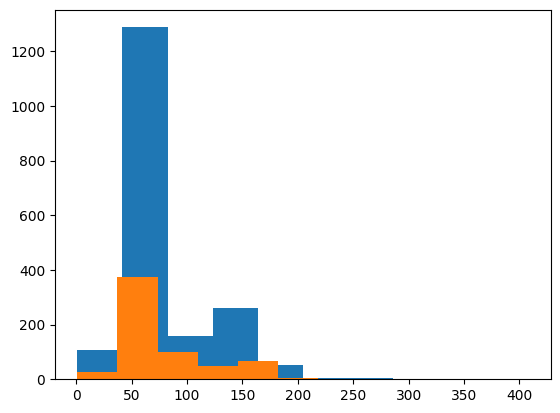

In [6]:
# Distribution plot of ground altitude
plt.hist(datasets["train"][1]);
plt.hist(datasets["val"][1]);
plt.show()

## Simple Linear regression (Baseline)

In [7]:
LR1 = LinearRegression().fit(datasets["train"][0], datasets["train"][1])
train_predict = LR1.predict(datasets["train"][0])
val_predict = LR1.predict(datasets["val"][0])
t_loss=loss_func(datasets['train'][1],train_predict)
v_loss= loss_func(datasets['val'][1],val_predict)
print(f"Train loss: {t_loss}, Val Loss: {v_loss}, Diff: {abs(t_loss-v_loss)})")

""" There is huge differnce between train and validation loss, which signifies the overfitting of the model"""

Train loss: 1406.2856831476201, Val Loss: 1632.8833538624049, Diff: 226.59767071478473)


' There is huge differnce between train and validation loss, which signifies the overfitting of the model'

## Neural Network (Regression Problem)

In [8]:
class MlabsDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x_transform =  scaler.fit_transform(x)
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        return torch.tensor(self.x_transform[idx],dtype=torch.float32), torch.tensor(self.y[idx],dtype=torch.float32)

    def __len__(self):
        return len(self.x)

In [9]:
# Simple Neural Network Model

class LinearModel1(torch.nn.Module):

    def __init__(self):
        super(LinearModel1, self).__init__()

        self.linear1 = torch.nn.Linear(2, 1)

    def forward(self, x):
        x = self.linear1(x)
        return x

NN_LR1 = LinearModel1()

In [10]:
class LinearModel2(torch.nn.Module):

    def __init__(self):
        super(LinearModel2, self).__init__()

        self.linear1 = torch.nn.Linear(2, 10)
        self.linear2 = torch.nn.Linear(10, 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)

        return x

In [11]:
loss_fn   = torch.nn.functional.mse_loss

In [12]:
def train_one_epoch(epoch_index,train_dataloader,model,optimizer):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(train_dataloader):
        # Every data instance is an input + label pair
        inputs, labels = data
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
    last_loss = running_loss/i+1
        
    #print('Loss Train: {}'.format(last_loss))

    return last_loss

In [13]:
def train(train_dataset, val_dataset, model):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001,momentum=0.5)
    EPOCHS = 50
    BATCH_SIZE=100
    avg_vloss=0
    for epoch in range(EPOCHS):
        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_dataloader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
        
        print('EPOCH {}:'.format(epoch + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch, train_dataloader,model,optimizer)


        running_vloss = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(val_dataloader):
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss.item()

        avg_vloss = running_vloss / (i + 1)
        print('LOSS train : {} valid : {}'.format(avg_loss, avg_vloss))
    return (avg_loss, avg_vloss)

In [14]:
NN_LR1 = LinearModel1()
train_dataset = MlabsDataset(datasets["train"][0],datasets["train"][1])
val_dataset   = MlabsDataset(datasets["val"][0],datasets["val"][1])
_= train(train_dataset,val_dataset,NN_LR1)

EPOCH 1:
LOSS train : 8400.691813151041 valid : 7974.308035714285
EPOCH 2:
LOSS train : 7427.656331380208 valid : 7173.979282924107
EPOCH 3:
LOSS train : 6587.370442708333 valid : 6559.528599330357
EPOCH 4:
LOSS train : 5853.033772786458 valid : 5621.61083984375
EPOCH 5:
LOSS train : 5253.326524522569 valid : 5267.274693080357
EPOCH 6:
LOSS train : 4706.0680745442705 valid : 4690.59441266741
EPOCH 7:
LOSS train : 4248.450005425348 valid : 4259.097935267857
EPOCH 8:
LOSS train : 3855.5458713107637 valid : 4203.94011579241
EPOCH 9:
LOSS train : 3517.888373480903 valid : 3553.0697893415177
EPOCH 10:
LOSS train : 3248.4578450520835 valid : 3310.9935128348216
EPOCH 11:
LOSS train : 2992.642727322049 valid : 3592.4824567522323
EPOCH 12:
LOSS train : 2791.348836263021 valid : 2817.551199776786
EPOCH 13:
LOSS train : 2580.341559516059 valid : 2697.0556640625
EPOCH 14:
LOSS train : 2423.2894897460938 valid : 2524.494873046875
EPOCH 15:
LOSS train : 2296.064927842882 valid : 2385.5374058314733
E

In [15]:
NN_LR2 = LinearModel2()
_= train(train_dataset,val_dataset,NN_LR2)

EPOCH 1:
LOSS train : 5385.623155381944 valid : 1381.998570033482
EPOCH 2:
LOSS train : 1147.1556023491753 valid : 1119.5468924386162
EPOCH 3:
LOSS train : 974.4873657226562 valid : 1022.9286063058036
EPOCH 4:
LOSS train : 898.5367465549045 valid : 1056.0291137695312
EPOCH 5:
LOSS train : 878.7646077473959 valid : 958.0270124162946
EPOCH 6:
LOSS train : 858.885243733724 valid : 983.274884905134
EPOCH 7:
LOSS train : 851.6607699924045 valid : 902.7077178955078
EPOCH 8:
LOSS train : 845.4117753770616 valid : 1039.5171857561384
EPOCH 9:
LOSS train : 830.1049363878038 valid : 1117.6905168805804
EPOCH 10:
LOSS train : 836.6263885498047 valid : 938.1904732840402
EPOCH 11:
LOSS train : 822.768812391493 valid : 1011.0205165318081
EPOCH 12:
LOSS train : 820.039791531033 valid : 904.4007088797433
EPOCH 13:
LOSS train : 814.0940890842014 valid : 895.2045157296317
EPOCH 14:
LOSS train : 815.9954172770182 valid : 893.6973397391183
EPOCH 15:
LOSS train : 811.7593621148003 valid : 902.8133806501116
E

In [16]:
# Basis Function
def Basis_function(centers, cordinates):
    modified_cord = []
    for i in range(centers.shape[0]):
        modified_cord.append(np.exp(-np.linalg.norm(cordinates-centers[i], axis=1)))
    modified_cord = np.vstack(modified_cord).T
    return  modified_cord

In [17]:
indices = np.random.randint(0, datasets["train"][0].shape[0], size=10)
selected_centers = datasets["train"][0][indices,:]

datasets["mod_train"] = (Basis_function(selected_centers, datasets["train"][0]), datasets["train"][1])
datasets["mod_val"]  = (Basis_function(selected_centers, datasets["val"][0]), datasets["val"][1])

train_dataset = MlabsDataset(datasets["mod_train"][0],datasets["mod_train"][1])
val_dataset   = MlabsDataset(datasets["mod_val"][0],datasets["mod_val"][1])

In [18]:
class LinearModel3(torch.nn.Module):

    def __init__(self):
        super(LinearModel3, self).__init__()

        self.linear1 = torch.nn.Linear(10, 1)

    def forward(self, x):
        x = self.linear1(x)

        return x

In [19]:
NN_LR3 = LinearModel3() 
_= train(train_dataset, val_dataset, NN_LR3)

EPOCH 1:
LOSS train : 8334.966552734375 valid : 8218.286900111607
EPOCH 2:
LOSS train : 7360.535617404514 valid : 7124.525111607143
EPOCH 3:
LOSS train : 6523.498263888889 valid : 6211.936244419643
EPOCH 4:
LOSS train : 5779.655110677083 valid : 5576.191196986607
EPOCH 5:
LOSS train : 5159.331027560764 valid : 4927.444614955357
EPOCH 6:
LOSS train : 4640.056939019098 valid : 4431.029017857143
EPOCH 7:
LOSS train : 4170.6434326171875 valid : 4115.786516462053
EPOCH 8:
LOSS train : 3777.494588216146 valid : 3878.8938337053573
EPOCH 9:
LOSS train : 3431.8019341362847 valid : 3496.3318219866073
EPOCH 10:
LOSS train : 3145.3649088541665 valid : 3194.4660295758927
EPOCH 11:
LOSS train : 2911.043362087674 valid : 2988.0850655691966
EPOCH 12:
LOSS train : 2682.9179958767363 valid : 2651.8675537109375
EPOCH 13:
LOSS train : 2498.4315049913193 valid : 2506.3288922991073
EPOCH 14:
LOSS train : 2341.3462592230903 valid : 2463.6815185546875
EPOCH 15:
LOSS train : 2210.3064236111113 valid : 2330.752

In [20]:
class LinearModel4(torch.nn.Module):

    def __init__(self, ip_feat_size):
        super(LinearModel4, self).__init__()

        self.linear1 = torch.nn.Linear(ip_feat_size, 64)
        self.linear2 = torch.nn.Linear(64, 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)

        return x

In [22]:
NN_LR4 = LinearModel4(ip_feat_size=10) 
train(train_dataset, val_dataset, NN_LR4)

EPOCH 1:
LOSS train : 4911.041639539931 valid : 1508.7042497907366
EPOCH 2:
LOSS train : 1643.863518608941 valid : 1811.5776192801338
EPOCH 3:
LOSS train : 1535.4169582790798 valid : 1499.0858503069196
EPOCH 4:
LOSS train : 1536.3339063856338 valid : 1825.5840715680804
EPOCH 5:
LOSS train : 1458.6308695475261 valid : 1484.43510219029
EPOCH 6:
LOSS train : 1496.3675401475693 valid : 1950.7861502511162
EPOCH 7:
LOSS train : 1548.103244357639 valid : 1446.7027064732142
EPOCH 8:
LOSS train : 1488.844774034288 valid : 1447.4829363141741
EPOCH 9:
LOSS train : 1543.5538770887588 valid : 1810.650111607143
EPOCH 10:
LOSS train : 1447.9234381781685 valid : 1588.2296404157366
EPOCH 11:
LOSS train : 1510.009029812283 valid : 1669.504115513393
EPOCH 12:
LOSS train : 1445.0149298773872 valid : 1702.4158761160713
EPOCH 13:
LOSS train : 1452.4154391818577 valid : 1719.9056222098213
EPOCH 14:
LOSS train : 1475.686262342665 valid : 1400.785191127232
EPOCH 15:
LOSS train : 1476.1310492621528 valid : 1677

(1421.099806043837, 1379.6765616280693)

Above Randomly selected 10 coordinate points from the grid as the centers and then calculated the distances of each point with the selected centers. 
The difference between train and validation loss has decreased as copmared to the simple linear regression approach. 

In [23]:
loss = []
basis_count = []
for num_basis in range(10,100):
    indices          = np.random.randint(0, datasets["train"][0].shape[0], size=num_basis)
    selected_centers = datasets["train"][0][indices,:]

    datasets["mod_train"] = (Basis_function(selected_centers, datasets["train"][0]), datasets["train"][1])
    datasets["mod_val"]   = (Basis_function(selected_centers, datasets["val"][0]), datasets["val"][1])

    train_dataset = MlabsDataset(datasets["mod_train"][0],datasets["mod_train"][1])
    val_dataset   = MlabsDataset(datasets["mod_val"][0],datasets["mod_val"][1])

    NN_LR4 = LinearModel4(ip_feat_size=num_basis) 
    train_loss, val_loss = train(train_dataset, val_dataset, NN_LR4)
    loss.append((train_loss, val_loss))
    basis_count.append(num_basis)

EPOCH 1:
LOSS train : 5475.774515787761 valid : 1658.6312866210938
EPOCH 2:
LOSS train : 1529.34083726671 valid : 1488.4915161132812
EPOCH 3:
LOSS train : 1521.6385599772136 valid : 1632.1473388671875
EPOCH 4:
LOSS train : 1507.5731065538193 valid : 1504.00679234096
EPOCH 5:
LOSS train : 1531.8390096028645 valid : 1635.2020438058037
EPOCH 6:
LOSS train : 1566.9378628200955 valid : 1548.680463518415
EPOCH 7:
LOSS train : 1552.794630262587 valid : 1468.3417096819196
EPOCH 8:
LOSS train : 1429.8152398003472 valid : 1705.9351632254463
EPOCH 9:
LOSS train : 1507.3536919487847 valid : 1798.1004900251116
EPOCH 10:
LOSS train : 1452.5716756184895 valid : 1643.704380580357
EPOCH 11:
LOSS train : 1450.195095486111 valid : 1547.1658238002233
EPOCH 12:
LOSS train : 1481.8804456922744 valid : 1654.1119035993304
EPOCH 13:
LOSS train : 1438.943138970269 valid : 1532.3940168108259
EPOCH 14:
LOSS train : 1460.0149298773872 valid : 1490.1597464425224
EPOCH 15:
LOSS train : 1468.0781928168403 valid : 153

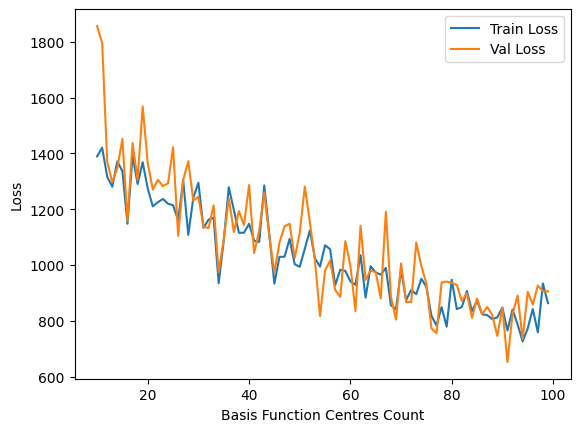

In [24]:
plt.plot(basis_count, [l[0] for l in loss], label="Train Loss")
plt.plot(basis_count, [l[1] for l in loss], label="Val Loss")
plt.legend()
plt.xlabel("Basis Function Centres Count")
plt.ylabel("Loss")
plt.show()

As from the graph above we can see that as the number of basis function centres increasing, the train and validation loss is decresing.

In [25]:
## Selecting all training instance as basis function centres

indices          = np.random.randint(0, datasets["train"][0].shape[0], size=num_basis)
selected_centers = datasets["train"][0]

datasets["mod_train"] = (Basis_function(selected_centers, datasets["train"][0]), datasets["train"][1])
datasets["mod_val"]   = (Basis_function(selected_centers, datasets["val"][0]), datasets["val"][1])

train_dataset = MlabsDataset(datasets["mod_train"][0],datasets["mod_train"][1])
val_dataset   = MlabsDataset(datasets["mod_val"][0],datasets["mod_val"][1])

NN_LR4 = LinearModel4(ip_feat_size=datasets["train"][0].shape[0]) 
train_loss, val_loss = train(train_dataset, val_dataset, NN_LR4)

EPOCH 1:
LOSS train : 3631.924341837565 valid : 1282.2701590401787
EPOCH 2:
LOSS train : 359.2943115234375 valid : 602.6976405552456
EPOCH 3:
LOSS train : 99.12307760450575 valid : 657.2939889090402
EPOCH 4:
LOSS train : 53.601662423875595 valid : 604.19677734375
EPOCH 5:
LOSS train : 40.66910727818807 valid : 599.311015537807
EPOCH 6:
LOSS train : 29.325244161817764 valid : 579.123801095145
EPOCH 7:
LOSS train : 21.58594759305318 valid : 673.9334629603794
EPOCH 8:
LOSS train : 17.416933404074776 valid : 600.7384163992746
EPOCH 9:
LOSS train : 14.674651371108162 valid : 635.7433776855469
EPOCH 10:
LOSS train : 10.38430262936486 valid : 592.7828412737165
EPOCH 11:
LOSS train : 8.711425814363691 valid : 554.358396257673
EPOCH 12:
LOSS train : 6.282110644711389 valid : 611.9625767299107
EPOCH 13:
LOSS train : 5.3139457901318865 valid : 579.2473929268973
EPOCH 14:
LOSS train : 4.034443044000202 valid : 640.8978663853237
EPOCH 15:
LOSS train : 3.440178394317627 valid : 575.0086277553013
EPO

In [26]:
print(f"Train loss: {train_loss}, Validation loss: {val_loss} after selecting all the training points as basis function centres.")

Train loss: 1.0553021055085183, Validation loss: 635.1661812918527 after selecting all the training points as basis function centres.


In [34]:
# Best way to select the basis function centres

selected_centers =  np.array([[0,0],[0,25],[0,50],[25,0],[50,0],[50,25],[50,50]])
datasets["mod_train"] = (Basis_function(selected_centers, datasets["train"][0]), datasets["train"][1])
datasets["mod_val"]   = (Basis_function(selected_centers, datasets["val"][0]), datasets["val"][1])

train_dataset = MlabsDataset(datasets["mod_train"][0],datasets["mod_train"][1])
val_dataset   = MlabsDataset(datasets["mod_val"][0],datasets["mod_val"][1])

NN_LR4 = LinearModel4(ip_feat_size=len(selected_centers)) 
train_loss, val_loss = train(train_dataset, val_dataset, NN_LR4)

EPOCH 1:
LOSS train : 4702.384704589844 valid : 1878.171866280692
EPOCH 2:
LOSS train : 1569.26609632704 valid : 1613.1373639787946
EPOCH 3:
LOSS train : 1503.4459092881943 valid : 1588.4231654575892
EPOCH 4:
LOSS train : 1503.9499172634548 valid : 1785.849853515625
EPOCH 5:
LOSS train : 1495.2770555284287 valid : 1624.158482142857
EPOCH 6:
LOSS train : 1489.3900248209636 valid : 1491.3254220145088
EPOCH 7:
LOSS train : 1484.7808770073784 valid : 1757.426234654018
EPOCH 8:
LOSS train : 1468.7171359592014 valid : 1538.5819440569196
EPOCH 9:
LOSS train : 1565.3128865559895 valid : 1682.1642020089287
EPOCH 10:
LOSS train : 1527.9957546657986 valid : 1728.129682268415
EPOCH 11:
LOSS train : 1486.935526529948 valid : 1715.2751639229912
EPOCH 12:
LOSS train : 1507.9042256673176 valid : 1637.8431745256696
EPOCH 13:
LOSS train : 1487.3419664171006 valid : 1579.468470982143
EPOCH 14:
LOSS train : 1482.6180555555557 valid : 1590.56352015904
EPOCH 15:
LOSS train : 1482.6456163194443 valid : 1509.

Based on the outcome above, it's clear that when the selected center points are more distant from each other, the gap between training and validation loss smaller. Hence, it's advisable to choose a maximum number of basis function centers ensuring they are widely spaced apart.

Another approach to consider is modeling using CNN for pixel labeling. If the grid size is larger, it might be advantageous to segment the grid into multiple smaller grids. 
Subsequently, one can generate the dataset and then apply the machine learning algorithm.